In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import sys
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA

sys.path.append('../src')
from fuzzy_elpigraph import Fuzzy_ElpiGraph
from lizard_brain import lizard_brain
from utils import draw_graph2D


class VQEmbeddingEMA(nn.Module):
    def __init__(self, n_embeddings, embedding_dim, commitment_cost=0.25, decay=0.999, epsilon=1e-5):
        super(VQEmbeddingEMA, self).__init__()
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.epsilon = epsilon
        
        init_bound = 1 / n_embeddings
        embedding = torch.Tensor(n_embeddings, embedding_dim)
        embedding.uniform_(-init_bound, init_bound)
        self.register_buffer("embedding", embedding)
        self.register_buffer("ema_count", torch.zeros(n_embeddings))
        self.register_buffer("ema_weight", self.embedding.clone())

    def encode(self, x):
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)

        distances = (-torch.cdist(x_flat, self.embedding, p=2)) ** 2

        indices = torch.argmin(distances.float(), dim=-1)
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)
        return quantized, indices.view(x.size(0), x.size(1))
    
    def retrieve_random_codebook(self, random_indices):
        quantized = F.embedding(random_indices, self.embedding)
        quantized = quantized.transpose(1, 3)
        
        return quantized

    def forward(self, x):
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)
        
        distances = (-torch.cdist(x_flat, self.embedding, p=2)) ** 2

        indices = torch.argmin(distances.float(), dim=-1)
        encodings = F.one_hot(indices, M).float()
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)
        
        if self.training:
            self.ema_count = self.decay * self.ema_count + (1 - self.decay) * torch.sum(encodings, dim=0)
            n = torch.sum(self.ema_count)
            self.ema_count = (self.ema_count + self.epsilon) / (n + M * self.epsilon) * n

            dw = torch.matmul(encodings.t(), x_flat)
            self.ema_weight = self.decay * self.ema_weight + (1 - self.decay) * dw
            self.embedding = self.ema_weight / self.ema_count.unsqueeze(-1)

        codebook_loss = F.mse_loss(x.detach(), quantized)
        e_latent_loss = F.mse_loss(x, quantized.detach())
        commitment_loss = self.commitment_cost * e_latent_loss

        quantized = x + (quantized - x).detach()

        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return quantized, commitment_loss, codebook_loss, perplexity



class MLP_Encoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(MLP_Encoder, self).__init__()
        self.encoder = torch.nn.Sequential(
                    torch.nn.Linear(input_dim, hidden_dim),
                    torch.nn.Sigmoid(),
                    #torch.nn.LeakyReLU(),
                    #torch.nn.Linear(hidden_dim, hidden_dim),
                    #torch.nn.Sigmoid(),
                    torch.nn.Linear(hidden_dim, latent_dim),
                    torch.nn.BatchNorm1d(latent_dim,affine=False)
                )        

    def forward(self, x):
        x = self.encoder(x)
        return x
    
class MLP_Decoder(torch.nn.Module):
    def __init__(self, output_dim, hidden_dim, latent_dim):
        super(MLP_Decoder, self).__init__()
        self.decoder = torch.nn.Sequential(
                    torch.nn.Linear(latent_dim, hidden_dim),
                    torch.nn.Sigmoid(),
                    #torch.nn.LeakyReLU(),
                    #torch.nn.Linear(hidden_dim, hidden_dim),
                    #torch.nn.Sigmoid(),
                    torch.nn.Linear(hidden_dim, output_dim),
                    #torch.nn.BatchNorm1d(output_dim)
                    #torch.nn.Sigmoid()
                )        

    def forward(self, x):
        x = self.decoder(x)
        return x
    
class MLP_AE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(MLP_AE, self).__init__()
        self.encoder = MLP_Encoder(input_dim,hidden_dim,latent_dim)
        self.decoder = MLP_Decoder(input_dim,hidden_dim,latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        y = self.decoder(x)
        return y

class MLP_VQ_VAE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, n_clusters):
        super(MLP_VQ_VAE, self).__init__()
        self.encoder = MLP_Encoder(input_dim,hidden_dim,latent_dim)
        self.decoder = MLP_Decoder(input_dim,hidden_dim,latent_dim)
        self.codebook = VQEmbeddingEMA(n_embeddings=n_clusters, embedding_dim=latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        xq, commitment_loss, codebook_loss, perplexity = self.codebook(x)
        y = self.decoder(xq)
        return y, commitment_loss, codebook_loss, perplexity

class MLP_FELPIGRAPH(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, n_clusters, lmda=0.01, mu=0.1,intrinsicOptimization=False,numberIterations=50):
        super(MLP_FELPIGRAPH, self).__init__()
        self.encoder = MLP_Encoder(input_dim,hidden_dim,latent_dim)
        self.felpigraph = Fuzzy_ElpiGraph(latent_dim,n_clusters,numberIterations=numberIterations,
                                          lmda=lmda,mu=mu,intrinsicOptimization=intrinsicOptimization)
        self.decoder = MLP_Decoder(input_dim,hidden_dim,latent_dim)
        self.initialized = False
        self.intrinsicOptimization = intrinsicOptimization
        self.pretrain_optimizer = torch.optim.Adam(self.parameters(),
                                          lr=5e-3,
                                          weight_decay=1e-7)
    
    def pretrain(self,x,verbose=True,numberIterations=200):
        numiter =numberIterations
        optim = self.pretrain_optimizer
        if verbose:
            print(f'Pretraining: {numiter=}')
        mse_loss = nn.MSELoss()
        for i in range(numiter):

            xlat = self.encoder(x)
            xhat = self.decoder(xlat)
            loss = mse_loss(x,xhat)

            optim.zero_grad()
            if verbose:
                print(f'step={i+1},MSE={(loss.item())}')
            loss.backward(retain_graph=True)
            optim.step()


    def forward(self, x):
        x = self.encoder(x)
        if not self.initialized:
            self.felpigraph._initNodePositions(x)
            self.felpigraph._intrinsic_optimization(x)
            self.felpigraph._computeFuzzyGraph()
            self.felpigraph._computeMST()
            self.felpigraph._intrinsic_optimization(x)
            self.initialized = True
            self.felpigraph._numberIterations = int(self.felpigraph._numberIterations/10)
        #self.felpigraph._computeFuzzyGraph()
        #self.felpigraph._computeMST()
        if self.intrinsicOptimization:
            self.felpigraph._intrinsic_optimization(x)
        _, loss = self.felpigraph.forward(x)
        #loss = self.felpigraph._getLoss(x)
        xhat = self.decoder(x)
        return xhat, self.felpigraph.y, loss


/home/zinovyev/gits/deep_fuzzy_elpigraph/notebooks/../src/lizard_brain.py:79: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  plt.plot(u[irx==lab,0],u[irx==lab,1],'k.',color=col,markersize=1,linewidth=1)


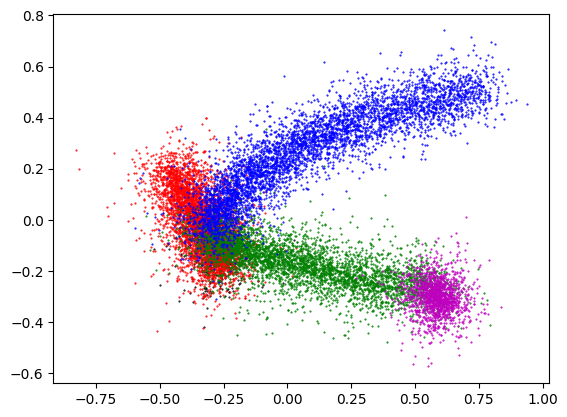

torch.Size([15131, 20])


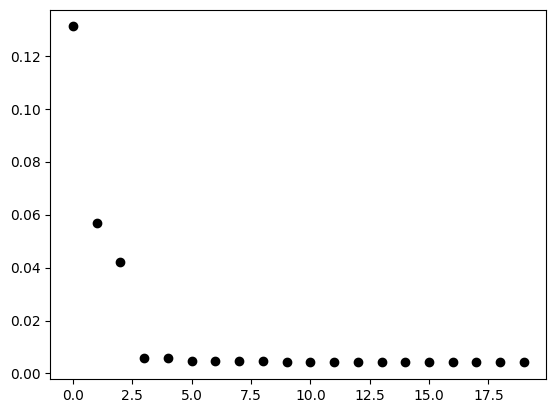

In [2]:
#np.random.seed(118)
np.random.seed(200)
#np.random.seed(2)
[X,irx,v,u,s] = lizard_brain(number_of_branches=3,dimension=20,show_fig=True,add_noise=0.05,epsilon=0.0002)
#np.random.seed(28)
#[X,irx,v,u,s] = lizard_brain(number_of_branches=3,dimension=20,show_fig=True,add_noise=0.03,epsilon=0.0002)
X = torch.tensor(X,dtype=torch.float)
print(X.shape)
plt.plot(s,'ko')
plt.show()
pd.DataFrame(X.numpy()).to_csv('../data/test.csv',index=None,header=None)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:01<00:00, 149.89it/s]


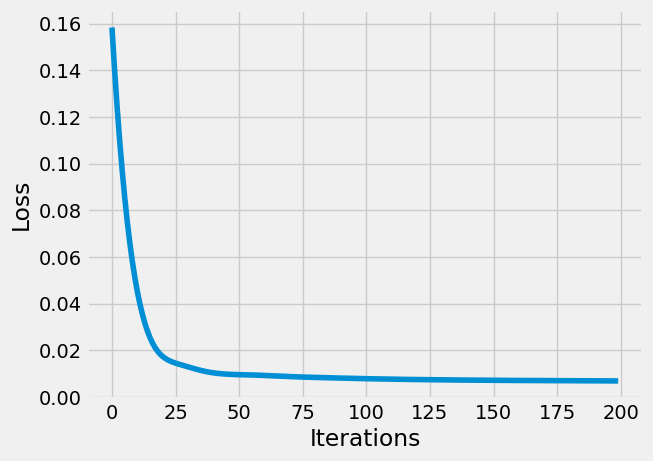

In [37]:
# Train simple MLP_AE

hidden_dim = 10
latent_dim = 3
model = MLP_AE(X.shape[1],hidden_dim,latent_dim)

# Validation using MSE Loss function
mse_loss = nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 5e-3,
                             weight_decay = 1e-5)

epochs = 200
outputs = []
losses = []
for epoch in tqdm(range(epochs)):
    reconstructed = model(X)
    loss = mse_loss(reconstructed, X)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.detach())

plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(losses)
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:06<00:00, 79.44it/s]


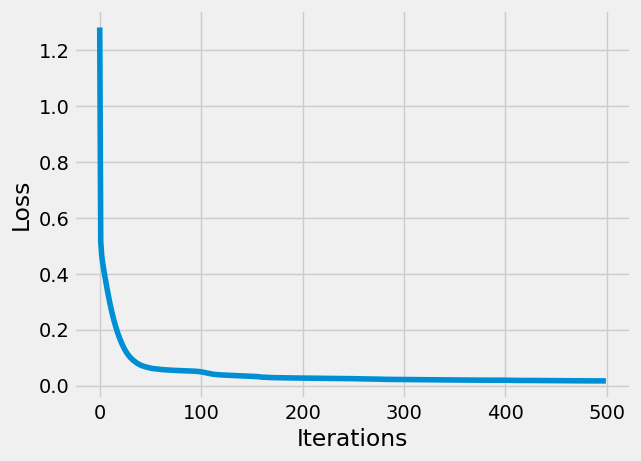

In [10]:
# Train simple MLP_VQ_VAE

hidden_dim = 10
latent_dim = 3
commitment_beta = 0.2
model = MLP_VQ_VAE(X.shape[1],hidden_dim,latent_dim,n_clusters=100)

# Validation using MSE Loss function
mse_loss = nn.MSELoss()
 
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 3e-3,
                             weight_decay = 1e-5)

epochs = 500
outputs = []
losses = []
for epoch in tqdm(range(epochs)):

    x_hat, commitment_loss, codebook_loss, perplexity = model(X)
    recon_loss = mse_loss(x_hat, X)
    
    loss =  recon_loss + commitment_loss * commitment_beta + codebook_loss
    #loss = recon_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.detach())

plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(losses)
plt.show()

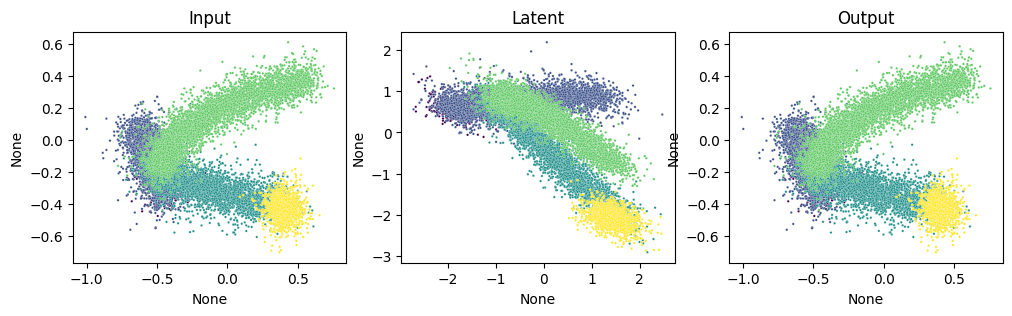

100%|██████████| 100/100 [00:01<00:00, 66.02it/s]


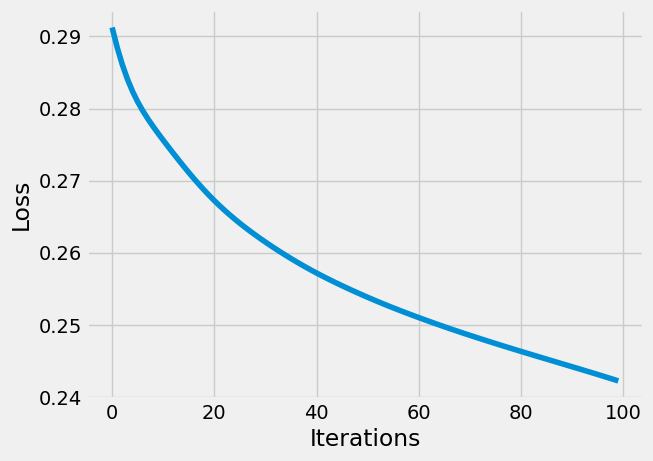

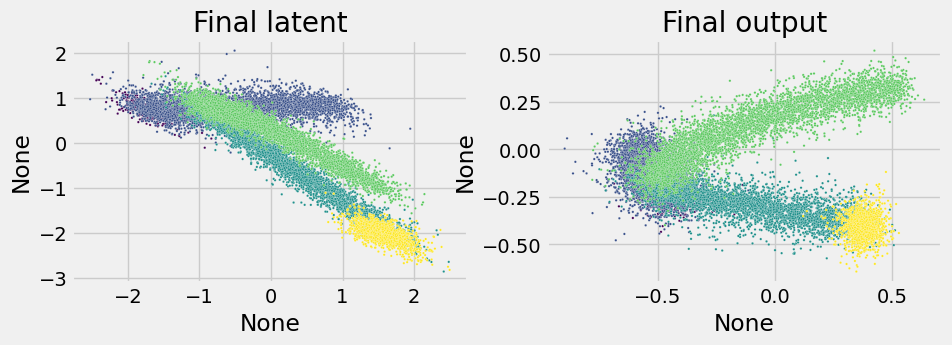

In [3]:
# Train  MLP_FELPIGRAPH

torch.manual_seed(1)

hidden_dim = 10
latent_dim = 3
elasticpenalty_weight = 1.0
model = MLP_FELPIGRAPH(X.shape[1],hidden_dim,latent_dim,n_clusters=30,lmda=0.01,mu=0.05,intrinsicOptimization=False)

model.pretrain(X,verbose=False)
fig, axs = plt.subplots(1,3,figsize=(12,3))
sns.scatterplot(x=X.detach()@v[:,0],y=X.detach()@v[:,1],c=irx,ax=axs[0],s=3)
axs[0].set_title('Input')
X1 = model.encoder(X)
sns.scatterplot(x=X1.detach()[:,0],y=X1.detach()[:,1],c=irx,ax=axs[1],s=3)
axs[1].set_title('Latent')
X1 = model(X)[0]
sns.scatterplot(x=X.detach()@v[:,0],y=X.detach()@v[:,1],c=irx,ax=axs[2],s=3)
axs[2].set_title('Output')
plt.show()

# Validation using MSE Loss function
mse_loss = nn.MSELoss()
 
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-3,
                             weight_decay = 1e-5)

epochs = 100
outputs = []
losses = []
for epoch in tqdm(range(epochs)):

    x_hat, y, felpigraph_loss = model(X)
    recon_loss = mse_loss(x_hat, X)

    loss =  recon_loss + felpigraph_loss*elasticpenalty_weight


    assert not np.isnan(loss.detach())
    
    #print(recon_loss.item(),felpigraph_loss.item(),loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.detach())

#model.felpigraph._initNodePositions(model.encoder(X))
#model.felpigraph._intrinsic_optimization(model.encoder(X),verbose=False)
#y, loss = model.felpigraph.forward(model.encoder(X))


plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(losses)
plt.show()

fig, axs = plt.subplots(1,2,figsize=(10,3))
X1 = model.encoder(X)
sns.scatterplot(x=X1.detach()[:,0],y=X1.detach()[:,1],c=irx,ax=axs[0],s=3)
axs[0].set_title('Final latent')
X1 = model(X)[0]
sns.scatterplot(x=X1.detach()@v[:,0],y=X1.detach()@v[:,1],c=irx,ax=axs[1],s=3)
axs[1].set_title('Final output')
plt.show()


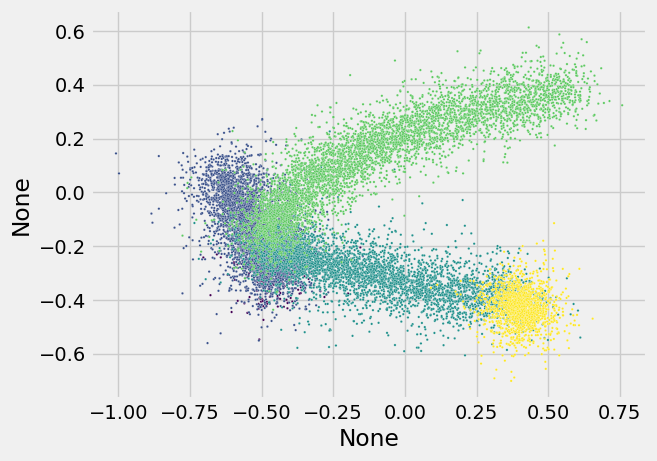

torch.Size([15131, 3])


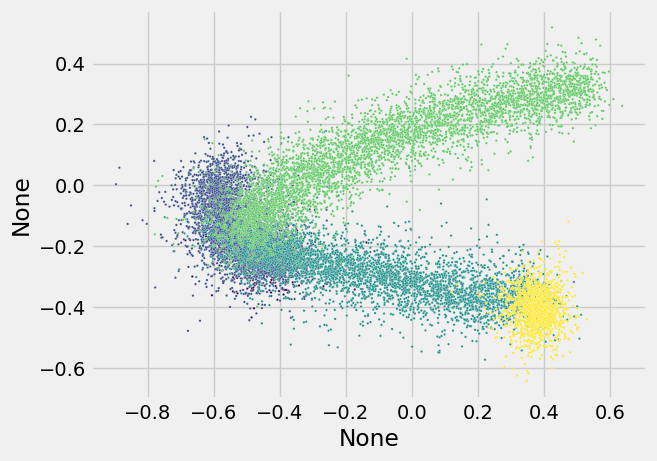

In [4]:
sns.scatterplot(x=X.detach()@v[:,0],y=X.detach()@v[:,1],c=irx,s=3)
plt.show()
Xlat = model.encoder(X)
print(Xlat.shape)
if False:
    sns.scatterplot(x=Xlat[:,0].detach(),y=Xlat[:,1].detach(),c=irx)
    plt.show()
    Xout = mlp_ae.decoder(Xlat)
    print(Xout.shape)
    sns.scatterplot(x=Xout[:,0].detach(),y=Xout[:,1].detach(),c=irx)
    plt.show()

if type(model).__name__=='MLP_VQ_VAE':
    X1 = model(X)[0]
    sns.scatterplot(x=X1.detach()@v[:,0],y=X1.detach()@v[:,1],c='k',s=100)
if type(model).__name__=='MLP_AE':
    X1 = model(X)
    sns.scatterplot(x=X1.detach()@v[:,0],y=X1.detach()@v[:,1],c=irx,s=3)
if type(model).__name__=='MLP_FELPIGRAPH':
    X1 = model(X)[0]
    sns.scatterplot(x=X1.detach()@v[:,0],y=X1.detach()@v[:,1],c=irx,s=3)


plt.show()


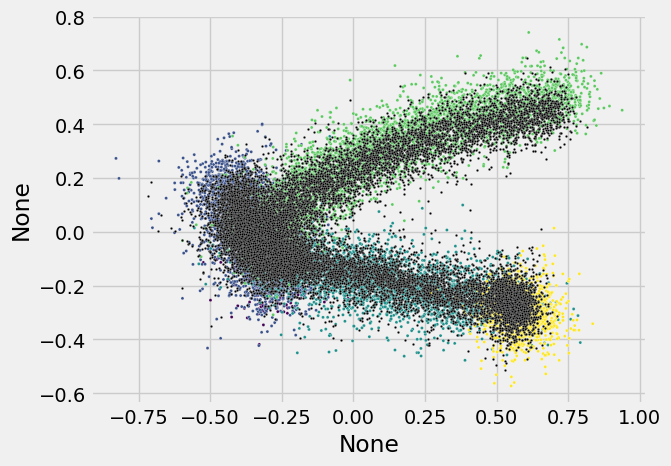

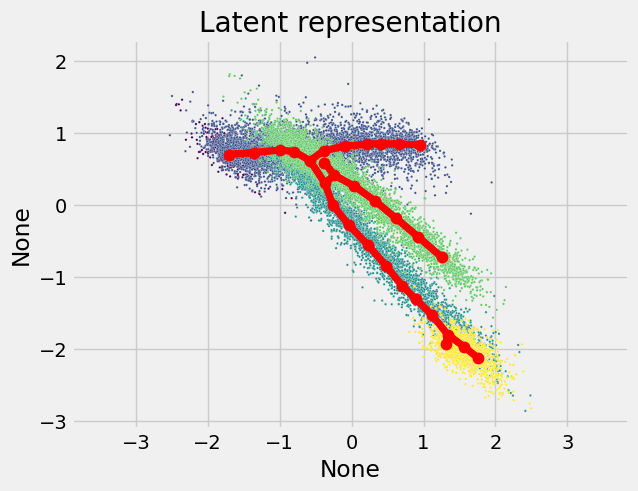

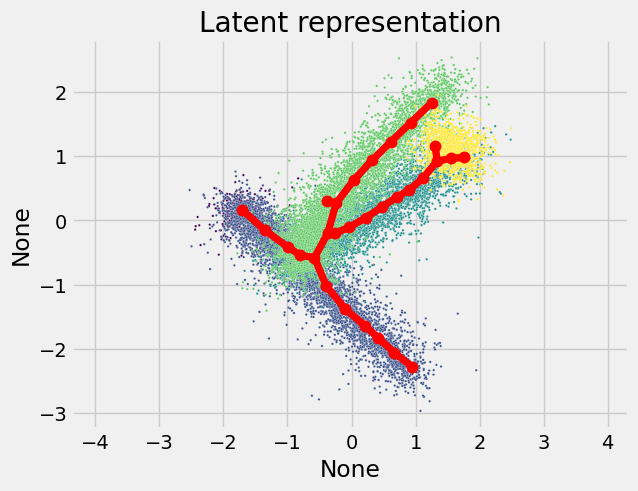

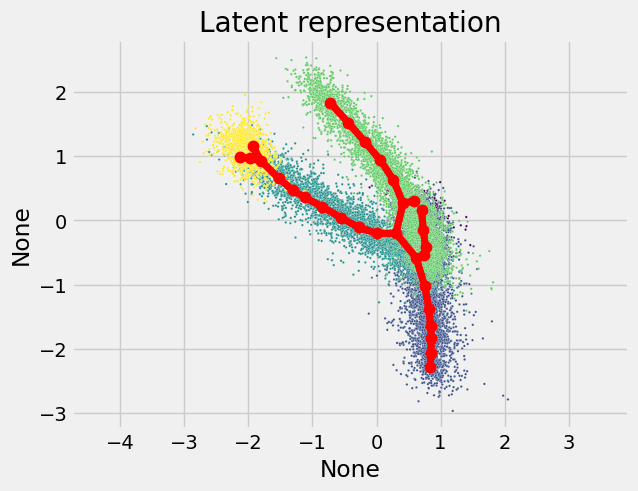

tensor(0.0040)


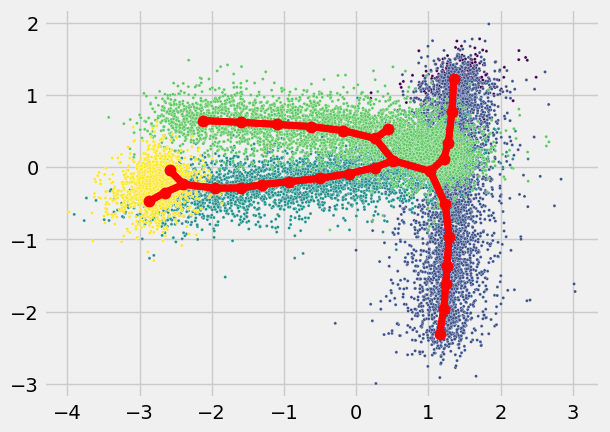

In [5]:
Xlat = model.encoder(X).detach()
if type(model).__name__=='MLP_VQ_VAE':
    X1 = model(X)[0].detach()
    Xlatq = model.codebook(Xlat)[0].detach()
    Xlatq1 = model.codebook.embedding.detach()
    Xtemp = Xlatq
    psize = 200
    clr = 'k'
if type(model).__name__=='MLP_AE':
    X1 = model(X).detach()
    Xtemp = Xlat
    psize = 3
    clr = irx
if type(model).__name__=='MLP_FELPIGRAPH':
    X1 = model(X)[0].detach()
    Xtemp = Xlat
    psize = 3
    clr = irx


mn = X.mean(axis=0)
Xp = (X-mn)@v
X1p = (X1-mn)@v

sns.scatterplot(x=Xp[:,0].detach(),y=Xp[:,1].detach(),c=irx,s=5)
sns.scatterplot(x=X1p[:,0].detach(),y=X1p[:,1].detach(),c='k',s=psize)
plt.show()
if type(model).__name__=='MLP_VQ_VAE':
    sns.scatterplot(x=Xlat[:,0],y=Xlat[:,1],s=3,c=irx)    
    #sns.scatterplot(x=Xlatq1[:,0],y=Xlatq1[:,1],s=100,c='b')    
sns.scatterplot(x=Xtemp[:,0],y=Xtemp[:,1],s=psize,c=clr)
if type(model).__name__=='MLP_FELPIGRAPH':
    draw_graph2D(Xtemp[:,[0,1]],y[:,[0,1]],model.felpigraph.A,scale=0.5,drawX=False,show=False)
plt.title('Latent representation')
plt.show()
if type(model).__name__=='MLP_VQ_VAE':
    sns.scatterplot(x=Xlat[:,0],y=Xlat[:,2],s=3,c=irx)    
sns.scatterplot(x=Xtemp[:,0],y=Xtemp[:,2],s=psize,c=clr)
if type(model).__name__=='MLP_FELPIGRAPH':
    draw_graph2D(Xtemp[:,[0,2]],y[:,[0,2]],model.felpigraph.A,scale=0.5,drawX=False,show=False)
plt.title('Latent representation')
plt.show()
if type(model).__name__=='MLP_VQ_VAE':
    sns.scatterplot(x=Xlat[:,1],y=Xlat[:,2],s=3,c=irx)    
sns.scatterplot(x=Xtemp[:,1],y=Xtemp[:,2],s=psize,c=clr)
if type(model).__name__=='MLP_FELPIGRAPH':
    draw_graph2D(Xtemp[:,[1,2]],y[:,[1,2]],model.felpigraph.A,scale=0.5,drawX=False,show=False)
plt.title('Latent representation')
plt.show()
loss = mse_loss(X1, X)
print(loss)

if type(model).__name__=='MLP_FELPIGRAPH':
    xhat, y, loss = model.forward(X)
    Xlat = model.encoder(X).detach()
    pca = PCA()
    u1 = pca.fit_transform(Xlat.detach().numpy())
    v1 = pca.components_.T
    coords = [0,1]
    #u1 = Xlat[:,coords]
    u1 = u1[:,coords]
    sns.scatterplot(x=u1[:,0],y=u1[:,1],c=irx,s=5)
    ypca = (y.detach()-Xlat.mean(axis=0))@v1[:,coords]
    #ypca = y[:,coords]
    #draw_graph2D(u,y.detach()@v,fepgr.A,scale=0.5,drawX=False)
    draw_graph2D(u1,ypca,model.felpigraph.A,scale=0.5,drawX=False)

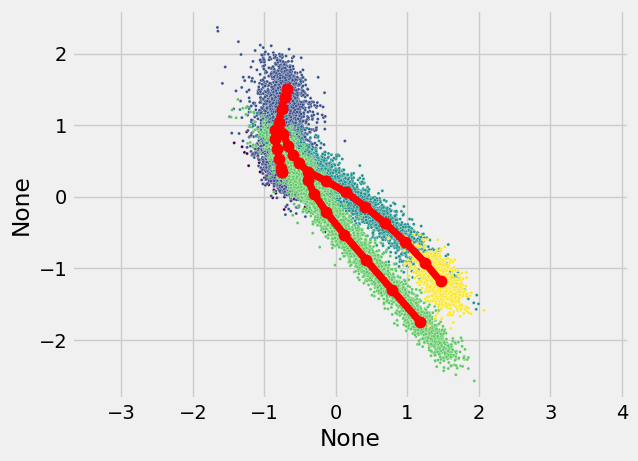

Parameter containing:
tensor([[ 0.4269, -1.2291, -0.8904],
        [-0.1350, -0.5389, -0.2141],
        [ 0.9682, -0.0647, -0.6298],
        [-0.8467,  0.8396,  0.8058],
        [-0.7582,  1.1626,  0.3479],
        [-0.8185,  0.9869,  0.6643],
        [ 1.2448, -0.2216, -0.9230],
        [-0.7610,  0.1943,  1.2342],
        [-0.5166,  0.4674,  0.4756],
        [-0.7566,  1.1762,  0.3396],
        [-0.7660,  1.1440,  0.3972],
        [-0.3907,  0.3397,  0.3491],
        [ 0.1176, -0.8626, -0.5298],
        [ 0.6866,  0.0906, -0.3692],
        [-0.1355,  0.3841,  0.2199],
        [ 0.7858, -1.6268, -1.3012],
        [-0.6690,  0.5430,  0.7167],
        [-0.3078, -0.2351,  0.0451],
        [ 1.4631, -0.3558, -1.1829],
        [-0.8504,  0.6613,  0.9392],
        [-0.7174, -0.0497,  1.3893],
        [ 0.4113,  0.2320, -0.1392],
        [-0.7993,  0.4644,  1.0346],
        [-0.7894,  1.0839,  0.5257],
        [ 1.1825, -2.0408, -1.7551],
        [-0.5994,  0.5313,  0.5900],
        [-0.3900

In [6]:
Xlat = model.encoder(X).detach()
pd.DataFrame(Xlat.numpy()).to_csv('../data/Xlat.csv',index=None,header=None)
fepgr = Fuzzy_ElpiGraph(Xlat.shape[1],number_of_nodes=30,computeMST=True,intrinsicOptimization=True,lmda=0.01,mu=0.1,alphaKmeans=5.0,alphaFuzzyGraph=5.0,intrinsicLearningRate=0.01)
fepgr._initNodePositions(Xlat)
fepgr._intrinsic_optimization(Xlat,verbose=False)
y, loss = fepgr.forward(Xlat)
pca = PCA()
u1 = pca.fit_transform(Xlat.detach().numpy())
v1 = pca.components_
coords = [0,2]
u1 = Xlat[:,coords]
sns.scatterplot(x=u1[:,0],y=u1[:,1],c=irx,s=5)
#draw_graph2D(u,y.detach()@v,fepgr.A,scale=0.5,drawX=False)
draw_graph2D(u1,y[:,coords],fepgr.A,scale=0.5,drawX=False)
print(fepgr.y)

In [9]:
n = 0
for p in model.parameters():
    n+=p.detach().numpy().ravel().shape[0]
print(n)

593


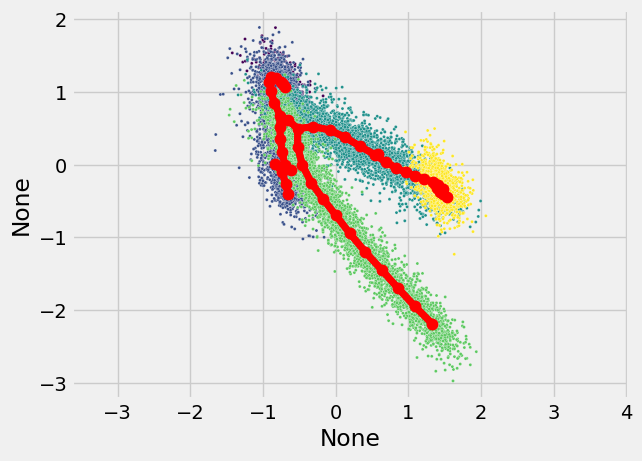

In [7]:
fepgr = Fuzzy_ElpiGraph(Xlat.shape[1],number_of_nodes=50,computeMST=True,intrinsicOptimization=True,lmda=0.01,mu=0.1,alphaKmeans=10.0,alphaFuzzyGraph=10.0)
fepgr._initNodePositions(Xlat)
fepgr._intrinsic_optimization(Xlat,verbose=False)
y, loss = fepgr.forward(Xlat)
pca = PCA()
u1 = pca.fit_transform(Xlat.detach().numpy())
v1 = pca.components_
coords = [0,1]
u1 = Xlat[:,coords]
sns.scatterplot(x=u1[:,0],y=u1[:,1],c=irx,s=5)
#draw_graph2D(u,y.detach()@v,fepgr.A,scale=0.5,drawX=False)
draw_graph2D(u1,y[:,coords],fepgr.A,scale=0.5,drawX=False)